In [6]:
############################
## Load required packages ##
############################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models.utils import initialize_COVID19_SEIQRD_spatial_rescaling

In [2]:
age_stratification_size = 10
agg='prov'
provincial=False
model, CORE_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_rescaling(age_stratification_size=age_stratification_size, agg=agg, provincial=provincial)

/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/data/utils.py:77: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index = age_classes)
/home/twallema/Documents/UGent/projects/Corona/code/COVID19-Model/src/covid19model/data/utils.py:77: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index = age_classes)


In [3]:
model.parameters['K_inf'] =  np.array([1.40, 1.80], np.float64)
model.parameters['K_hosp'] = np.array([1.60, 1.60], np.float64)

In [4]:
###################
## Run the model ##
###################
end_visualization = '2022-02-01'
start_calibration = '2020-03-17'
out = model.sim(end_visualization,start_date=start_calibration,warmup=0)

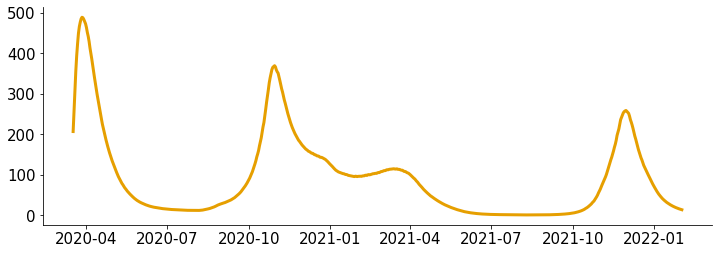

In [7]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(out['time'], out['H_in'].sum(dim='Nc').sum(dim='place'))
ax.grid(False)
plt.show()
plt.close()

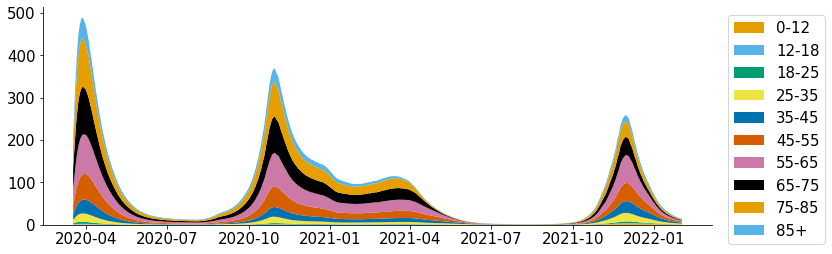

In [8]:
fig,ax=plt.subplots(figsize=(12,4))
ax.stackplot(out['time'].values, out['H_in'].sum(dim='place').values)
ax.legend(['0-12', '12-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85+'], bbox_to_anchor=(1.18,1))
ax.grid(False)
plt.show()
plt.close()

In [ ]:
E_hosp_function(pd.Timestamp(2021, 1, 1), 0, 0)

In [ ]:
# df_test.groupby(['date', 'NIS', 'age', 'dose']).first().loc[:,80000, pd.Interval(45,55,closed='left'), 'weighted_sum']['E_hosp'].plot()

first_name = 'weighted_'
name = 'sum'
df_test.groupby(['date', 'NIS', 'age', 'dose']).first().loc[:,80000, pd.Interval(45,55,closed='left'), f'{first_name}{name}']

In [ ]:
# df_test2 = df_test.groupby(['date', 'NIS', 'age', 'dose']).first()
# df_test2.loc[('2020-12-28',10000,pd.Interval(0,12,closed='left'), 'weighted_sum'), 'E_susc'] = (df_test2.loc[('2020-12-28',10000,pd.Interval(0,12,closed='left')), 'E_susc'] * df_test2.loc[('2020-12-28',10000,pd.Interval(0,12,closed='left')), 'fraction']).sum()
# df_test2.groupby(['date', 'NIS', 'age', 'dose']).first()

initN, Nc_dict, params, CORE_samples_dict = model_parameters.get_COVID19_SEIQRD_parameters(spatial='prov')

In [ ]:
def waning_exp_delay(days, onset_days, E_init, E_best, E_waned):
    """
    Function that implements time-dependence of vaccine effect.

    Input
    -----
    days : float
        number of days after the novel vaccination
    onset_days : float
        number of days it takes for the vaccine to take full effect
    E_init : float
        vaccine-related rescaling value right before vaccination
    E_best : float
        rescaling value related to the best possible protection by the currently injected vaccine
    E_waned : float
        rescaling value related to the vaccine protection after a waning period.

    Output
    ------
    E_eff : float
        effective rescaling value associated with the newly administered vaccine

    """
    waning_days = 183 # hard-coded to half a year
    if days <= 0:
        return E_init
    elif days < onset_days:
        E_eff = (E_best - E_init)/onset_days*days + E_init
        return E_eff
    else:
        if E_best == E_waned:
            return E_best
        halftime_days = waning_days - onset_days
        A = 1-E_best
        beta = -np.log((1-E_waned)/A)/halftime_days
        E_eff = -A*np.exp(-beta*(days-onset_days))+1
    return E_eff

In [ ]:
def E_eff_func(df_inc, onset_days, E_init, E_best, E_waned):
    """
    Currently implemented for weekly data. Creates DataFrame with rescaling values for one particular VOC.
    
    Input
    -----
    
    t : pd.Timestamp
        Time at which we want to know the effective rescaling factor
    df_inc : pd.DataFrame
        DataFrame containing all incidence data. Output from df_inc = make_vaccination_function(vacc_data['INCIDENCE']).df
    onset_days : dict
        dict containing onset_days values for any rescaling type {'E_susc', 'E_inf', 'E_hosp'} and every vaccine stage {'first', 'full', 'booster'}
    E_init : dict
        dict containing initial rescaling values for any rescaling type {'E_susc', 'E_inf', 'E_hosp'} and every vaccine stage {'first', 'full', 'booster'}
    E_best : dict
        dict containing best rescaling values for any rescaling type {'E_susc', 'E_inf', 'E_hosp'} and every vaccine stage {'first', 'full', 'booster'}
    E_waned : dict
        dict containing waned rescaling values for any rescaling type {'E_susc', 'E_inf', 'E_hosp'} and every vaccine stage {'first', 'full', 'booster'}
    
    Output
    ------
    E_eff : np.array
        effective rescaling factor associated with a particular VOC type and a particular vaccination dose. Dimensions [G,N]
    """
    
    ### Make proper DataFrame
    # Rename column headers
    df_inc = df_inc.rename(index={'A' : 'first', 'B' : 'full', 'C' : 'janssen', 'E' : 'booster'})
    df_inc = df_inc.reset_index().set_index('date').rename(columns={0 : 'INCIDENCE'})
    
    # Add Janssen vaccins to full dose and delete Janssen vaccins
    df_inc.loc[df_inc['dose']=='full', 'INCIDENCE'] += df_inc.loc[df_inc['dose']=='janssen', 'INCIDENCE']
    df_inc = df_inc.groupby(['date','NIS','age', 'dose']).first().drop(index='janssen', level=3)
    
    # Add column with cumulative values
    df_inc['CUMULATIVE'] = df_inc.groupby(level=[1,2,3]).cumsum()
    
    ### Create column with rescaling value calculated from cum and inc values
    
    # initialise
    df_inc['E_susc'] = 0
    df_inc['E_inf'] = 0
    df_inc['E_hosp'] = 0

    # 
    df_inc = df_inc.reset_index()
    all_available_dates = df_inc.date.unique()
    df_inc = df_inc.set_index(['date', 'dose']).sort_index()
    for rescaling in ['E_susc', 'E_inf', 'E_hosp']:
        for dose in ['first', 'full', 'booster']:
            # Calculate E values for this rescaling type and dose
            onset_days_temp = onset_days[rescaling][dose]
            E_init_temp = E_init[rescaling][dose]
            E_best_temp = E_best[rescaling][dose]
            E_waned_temp = E_waned[rescaling][dose]
            for date in all_available_dates:
                # run over all dates before this date
                for d in all_available_dates[all_available_dates<=date]:
                    # Calculate how many days there are in between
                    delta_days = pd.Timedelta(date - d).days
                    # Sum over previous days with a weight depending on incidence, dose type, and waning of vaccines
                    weight = waning_exp_delay(delta_days, onset_days_temp, E_init_temp, E_best_temp, E_waned_temp)
                    df_inc.loc[(date, dose), rescaling] += df_inc.loc[(d, dose),'INCIDENCE'].to_numpy() * weight
                # normalise over total number of vaccinated subjects up to that point
                df_inc.loc[(date,dose), rescaling] /= df_inc.loc[(date,dose), 'CUMULATIVE']
        # Get rid of all division-by-zero results
        df_inc.loc[df_inc[rescaling]==np.inf, rescaling] = 1
        df_inc[rescaling].fillna(1, inplace=True)
    
    return df_inc

# test values
onset_days = dict({'E_susc' : {'first' : 14, 'full' : 14, 'booster' : 14},
               'E_inf' : {'first' : 14, 'full' : 14, 'booster' : 14},
               'E_hosp' : {'first' : 14, 'full' : 14, 'booster' : 14}})
# E_init is the value of the previous waned vaccine
E_init = dict({'E_susc' : {'first' : 1, 'full' : 0.8, 'booster' : 0.4},
               'E_inf' : {'first' : 1, 'full' : 0.5, 'booster' : 0.6},
               'E_hosp' : {'first' : 1, 'full' : 0.4, 'booster' : 0.5}})
E_best = dict({'E_susc' : {'first' : 0.4, 'full' : 0.3, 'booster' : 0.3},
               'E_inf' : {'first' : 0.5, 'full' : 0.4, 'booster' : 0.4},
               'E_hosp' : {'first' : 0.2, 'full' : 0.1, 'booster' : 0.1}})
E_waned = dict({'E_susc' : {'first' : 0.4, 'full' : 0.5, 'booster' : 0.3},
               'E_inf' : {'first' : 0.5, 'full' : 0.6, 'booster' : 0.4},
               'E_hosp' : {'first' : 0.2, 'full' : 0.2, 'booster' : 0.1}})

df_result = E_eff_func(0, df_inc, onset_days, E_init, E_best, E_waned)

In [ ]:
# df_result.loc[:,'booster',10000, pd.Interval(45,55,closed='left')]['E_hosp']
# df_result.groupby(['date', 'dose', 'NIS', 'age']).first().loc[:,'booster', 10000, pd.Interval(45,55,closed='left')]['E_hosp'].plot()

df_result.groupby(['date', 'NIS', 'age', 'dose']).first()

In [ ]:
df_temp = E_eff_func(0, df_inc, 0, 0)
df_temp = df_temp.reset_index().set_index(['date', 'dose'])
df_temp.loc[('2020-12-28', 'booster'), 'E_inf'] = 1
df_temp

In [ ]:
# case 1: cumsum = 0, so value doesn't contribute in overall sum. Return 1 (won't contribute)

# case 2: cumsum != 0, so value does contribute, weighted by how many subjects have been vaccinated yet

    
# df_cum_new = df_inc_new.groupby(level=[1,2,3]).cumsum()

# dates = df_inc_new.reset_index().date.unique()
# date = pd.Timestamp('2021, 05, 10')
# for d in dates[dates<=date]:

df_inc_temp = E_eff_func(0, df_inc, 0, 0)
df_new = df_inc_temp.reset_index()
all_available_dates = df_new.date.unique()
df_new = df_new.set_index(['date', 'dose'])
for rescaling in ['E_susc', 'E_inf', 'E_hosp']:
    for dose in ['first', 'full', 'booster']:
        for date in all_available_dates:
            # run over all dates before this date
            for d in dates[dates<=date]:
                # Calculate how many days there are in between
                delta_days = pd.Timedelta(date - d).days
                # Sum over previous days with a weight depending on incidence, dose type, and waning of vaccines
                df_new.loc[(date, dose), rescaling] += df_new.loc[(d, dose),'INCIDENCE'].to_numpy() * waning_exp_delay(delta_days, 21, 0.8, 0.2, 0.5)
            # normalise over total number of vaccinated subjects up to that point
            df_new.loc[(date,dose), rescaling] /= df_new.loc[(date,dose), 'CUMULATIVE']
    # Get rid of all division-by-zero results
    df_new.loc[df_new[rescaling]==np.inf, rescaling] = 1
    df_new[rescaling].fillna(1, inplace=True)
df_new

In [ ]:
df_temppp = df_new.drop(columns=['INCIDENCE', 'CUMULATIVE'])
df_temppp = df_temppp.reset_index().set_index(['date', 'NIS', 'age', 'dose'])
df_temppp.loc[:,10000, pd.Interval(45,55,closed='left'), 'booster']['E_susc'].plot()

In [ ]:
# df_new.loc[:, 10000, pd.Interval(25,35), 'full']

# df_new['E'].fillna(1, inplace=True)
df_new.groupby(['date', 'NIS', 'age', 'dose']).first().loc[:, 10000, pd.Interval(25,35,closed='left'), 'full']['E'].plot()

In [ ]:
df_new = df_new.groupby(['date', 'NIS', 'age', 'dose']).first()

df_new

In [ ]:

intervals = pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')
intervals_str = np.array(['[0, 12)', '[12, 18)', '[18, 25)', '[25, 35)', '[35, 45)', '[45, 55)', '[55, 65)', '[65, 75)', '[75, 85)', '[85, 120)'])
intervals_dict = dict({intervals_str[i] : intervals[i] for i in range(len(intervals))})
initN = initN.rename(columns=intervals_dict)

# initN_fulltable = initN.unstack().rename(column=dict({'age_class' : 'age'}))

df_new = pd.DataFrame(vacc_function.df).reset_index()
df_new = df_new.merge(initN.unstack().reset_index(), left_on=['NIS', 'age'], right_on=['NIS', 'age_class'])
df_new['fraction'] = df_new['0_x'] / df_new['0_y']
# df_new = df_new.drop(columns=['age_class', '0_x', '0_y'])
# df_new = df_new.set_index(['date', 'NIS', 'age', 'dose'])

# df_new.loc[:,:,:,'B']['fraction'] = df_new.loc[:,:,:,'A']['fraction'] - df_new.loc[:,:,:,'B']['fraction']
# df_new.loc[:,:,:,'A']['fraction']

df_new = df_new.set_index('date') # make sure we don't get NaN values because of mismatching indices
df_new_copy = df_new.copy()

# first-only: dose A (first) - dose B (second)
df_new.loc[df_new['dose']=='B','fraction'] = (df_new_copy.loc[df_new_copy['dose']=='A','fraction'] \
    - df_new_copy.loc[df_new_copy['dose']=='B','fraction']).clip(lower=0, upper=1)

# full: dose B (second) + dose C (Jansen) - dose E (booster)
df_new.loc[df_new['dose']=='C','fraction'] = (df_new_copy.loc[df_new_copy['dose']=='B','fraction'] \
    + df_new_copy.loc[df_new_copy['dose']=='C','fraction'] - df_new_copy.loc[df_new_copy['dose']=='E','fraction']).clip(lower=0, upper=1)

# booster: clip between 0 and 1. This is currently the latest stage
df_new.loc[df_new['dose']=='E','fraction'] = df_new_copy.loc[df_new_copy['dose']=='E', 'fraction'].clip(lower=0, upper=1)

# none. Rest category. Make sure all adds up to 1.
df_new.loc[df_new['dose']=='A','fraction'] = 1 - (df_new_copy.loc[df_new_copy['dose']=='B','fraction'] \
    - df_new_copy.loc[df_new_copy['dose']=='C','fraction'] - df_new_copy.loc[df_new_copy['dose']=='E','fraction']).clip(lower=0, upper=1)

# Return to multiindex
df_new = df_new.reset_index()
df_new = df_new.drop(columns=['age_class', '0_x', '0_y'])
df_new = df_new.set_index(['date','NIS', 'age', 'dose'])

# rename indices to clearly understandable categories
rename_indices = dict({'A' : 'none', 'B' : 'first', 'C' : 'full', 'E' : 'booster'})
df_new = df_new.rename(index=rename_indices)

# df_new_copy = df_new.copy()


In [ ]:
make_vaccination_function(vacc_data['CUMULATIVE']).df

In [ ]:
vacc_data.rename(index=dict({10000 : 'test'}))

                                                                                                                     
# initN

# initN.rename(columns=intervals_dict)

initN

In [ ]:
import datetime

df = pd.read_csv('../../data/raw/sciensano/COVID19BE_VACC_MUNI_raw.csv')

start=[]
end=[]
for year_week in df["YEAR_WEEK"].values:
    year = '20'+year_week[0:2]
    week = year_week[3:]
    if week == '53':
        week = str(int(year_week[3:])-1)

    startdate = "{}-{}-1".format(year, week)
    enddate = "{}-{}-6".format(year, week)

    dt = datetime.datetime.strptime(startdate, "%Y-%W-%w")
    start.append(dt.strftime("%Y-%m-%d"))

    dt = datetime.datetime.strptime(enddate, "%Y-%W-%w")
    end.append(dt.strftime("%Y-%m-%d"))
df['start_week'] = start
df['end_week'] = end

df

In [ ]:
######################
## Format dataframe ##
######################

df = df.drop(df[df.NIS5 == ''].index)
df = df.dropna()
df['CUMUL'][df['CUMUL'] == '<10'] = '0'
df['CUMUL'] = df['CUMUL'].astype(int)
df['NIS5'] = ((df['NIS5'].astype(float)).astype(int)).astype(str)
df = df.rename(columns={'NIS5':'NUTS5', 'AGEGROUP':'age'})
df.set_index('start_week')
df.pop('YEAR_WEEK')
df.pop('end_week')
df.set_index(['start_week','NUTS5','age','DOSE'], inplace=True)

In [ ]:
pd.concat?

In [ ]:
vacc_data